## Demo for GW Signal Injection 
This demonstration provides examples for the injection of GW signals. The waveforms of GWs may be input from analytical expressions, external codes, time series data, and SGWB spectra.
The simulations in this demo do not include noises, and noisy data can be generated by turning on the switch of noises in the simulator, or simply by superimposing the GWs and noises. 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
import healpy as hlp 

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Offset import *
from Triangle.Plot import *
from Triangle.Data import *
from Triangle.GW import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Cosmology import *

# np.random.seed(114514)

In [2]:
import multiprocessing
print('number of cpus =', multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None 

number of cpus = 12


## 1. Simulate GB signal 
The "unprojected" (the raw GW polarizations, not responsed by detectors) GW signal can be initialized by a "GWfunc" class, which must contain 2 functions "hpfunc" and "hcfunc" that return $h_+(t)$ and $h_\times(t)$ at given array of time. 

For example, for a Galactic binary system with circular orbit, the unprojected polarizations are: 
$$h_+(t) = A (1 + \cos^2 \iota) \cos \left[ \varphi \left(t\right) \right], \quad h_\times(t) = 2A \cos \iota \sin \left[ \varphi \left(t\right) \right]$$
where the phase of GW takes a Taylor expansion form: $\varphi(t) = 2\pi\left(f_0 t + \frac{1}{2}\dot{f}_0 t^2 + \frac{1}{6} \ddot{f}_0 t^3\right) + \varphi_0$.

### 1.1 Initialize GB waveform

In [3]:
gb = GB(
    A=1.39879192e-22, 
    f=0.00984299, 
    fdot=4.31168731e-16, 
    iota=2.29680093, 
    phi0=0.79960729
    )

### 1.2 Simulate interferomerty data 

#### data settings 

In [4]:
fsample = 0.1
data_time = 110 * DAY 
ifo_drop_time1 = 0 # in this tutorial we do not let the code drop the invalid data, but remove them by hand instead 
ifo_drop_time2 = 0
tdi_drop_time1 = 0
tdi_drop_time2 = 0
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 15 

In [5]:
orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB') 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(unit='ffd') 

#### initialize single-arm response 
The simulator uses a "GW" class (or a list of multiple GW classes) to generate the responses of interferometers. 

Each GW object represent a single GW signal, which should be initialized by:
- GWfunc: a GWfunc object;
- orbit: an Orbit object;
- ext_params: a list of 3 extrinsic parameters: [ecliptic longitude $\lambda$, ecliptic latitude $\beta$, polarization angle $\psi$].

The single-arm response can be represented by the doppler effect of laser frequency as:
$$s_{c, ij} = \nu_0 y_{ij}$$
where 
$$y_{ij}(t)
    = \frac{1}{2\left(1-\bm{\hat{k}} \cdot \bm{\hat{n}}_{ij}(t_i)\right)}\left[H_{ij}\left(t - \frac{d_{ij}(t)}{c} - \frac{\bm{\hat{k}} \cdot \bm{R}_j(t)}{c}\right) 
    -  H_{ij}\left(t - \frac{\bm{\hat{k}} \cdot \bm{R}_i(t)}{c}\right)\right]$$
and 
$$H_{ij} \equiv \bm{h} : \bm{\hat{n}}_{ij} \otimes \bm{\hat{n}}_{ij}$$

``NOTE`` that the GW class itself can calculate the single-arm response $y_{ij}$, which is nothing different from $s_{c, ij}$ (except for a constant factor). While to conduct  a more complete simulation, especially considering the conversion of time frames, we integrate the GW class into the whole Interferometor simulator. This would inevitably make the calculation much slower. 


In [6]:
lam = 4.50950561
beta = -0.30076513
psi = 3.08152927
gw = [GW(GWfunc=gb, orbit=orbit, ext_params=[lam, beta, psi]),] # for multiple sources, gw should be a list of GW objects, and the responses of them can be calculated in parallel

#### simulate interferometry data 

In [7]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2, 
    telemetry_downsample=None,
    detrend_order=None,
    acc_noise=False,
    ro_noise=False,
    laser_noise=False,
    clock_noise=False, 
    ob_noise=False, 
    bl_noise=False,
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw, 
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') # assume perfect detrending 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) # assume perfect synchronization to TCB 
m1.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

### 1.3 TDI combination 
GW signal is unchanged during the former 2 steps of TDI, i.e. for a GW-only data, 
$$\eta_{ij} = \xi_{ij} = s_{c, ij}$$
Therefore the TDI combination of $\eta_{ij}$ is actually the combination of $y_{ij}$.

In [8]:
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=interp_order, delay_order=5)
tdi.CalculateXi(doppler=False, pool=pool) # no need to use the doppler delay since there are no laser noise, and the effect of doppler term is totally negligible for GW.
tdi.CalculateEta(doppler=False)
tdi.FastMichelson(doppler=False, channel='AET')

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

#### plot TDI responses (in the fractional frequency difference unit)
By default the raw interferometry data is in frequency unit. Here we convert the data to the fractional frequency difference unit, which is more frequently used in GW data analysis. 
$${\rm fractional \ freqneucy \ difference} = \frac{\rm frequency}{\nu_0}, \ \nu_0 = 281.6 \ {\rm THz}$$
One may notice that data at the beginning are invalid due to interpolation. 

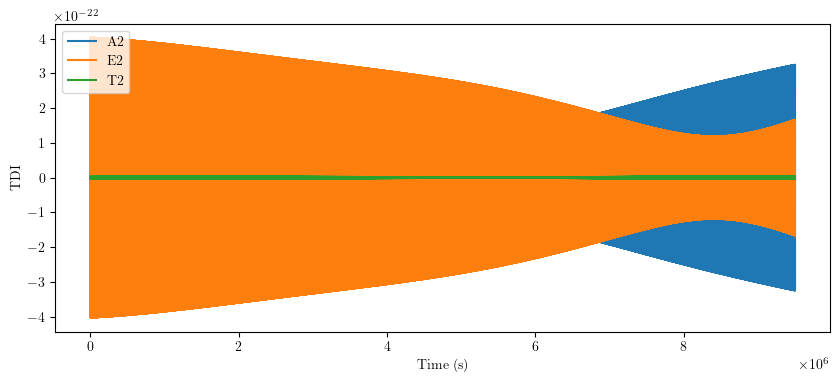

In [9]:
plt.figure(figsize=(10, 4))
for channel_name in ['A2', 'E2', 'T2']:
    plt.plot(tdi.measurements['time']['1'][100:-100], tdi.measurements[channel_name][100:-100] / F_LASER, label=channel_name)
plt.xlabel('Time (s)')
plt.ylabel('TDI')
plt.legend(loc="upper left")
# plt.xlim(100000,102000)

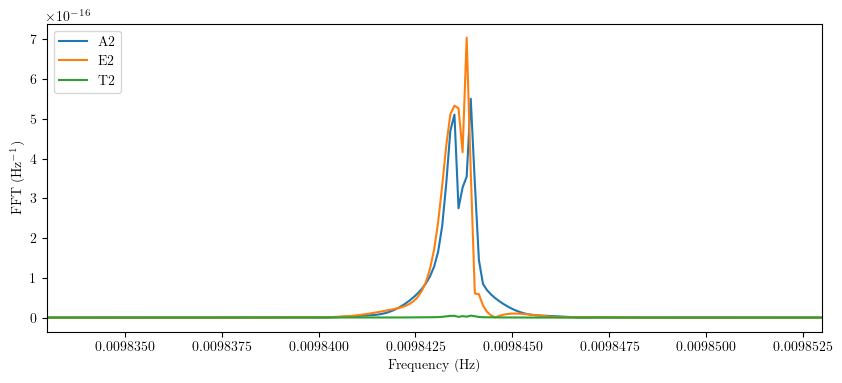

In [10]:
plt.figure(figsize=(10, 4))
for channel_name in ['A2', 'E2', 'T2']:
    ff, xf = FFT_window(data_array=tdi.measurements[channel_name][100:-100] / F_LASER, fsample=fsample, window_type="tukey", window_args_dict=dict(alpha=0.1))
    plt.plot(ff, np.abs(xf), label=channel_name)
plt.xlim(0.00984299-1e-5, 0.00984299+1e-5)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'${\rm FFT \ (Hz^{-1})}$')
plt.legend(loc="upper left")

## 2. Simulate MBHB signal using PyCBC
We showcase that external codes such as PyCBC can be used as the input of our simulator. 

### 1.1 Initialize MBHB waveform

In [11]:
# set parameters 
Mc = 400000.0
q = 0.3640815267051051
spin1z = 0.7899406190510447
spin2z = 0.015424596359292053
tc = 5. * DAY 
phic = 3.2535342675592966
D = 106039.10941463517
inc = 1.4495086550199021

# set waveform template 
approx = 'IMRPhenomD'

# set the sampling rate to generate unprojedted polarizations
dt = 1.

# initialize MBHB waveform
mbhb = MBHB(approx_method=approx, modes=None, buffer=True)
mbhb(Mc=Mc, q=q, spin1z=spin1z, spin2z=spin2z, tc=tc, phic=phic, D=D, inc=inc, dt=dt)


#### plot polarizations in the time domain 

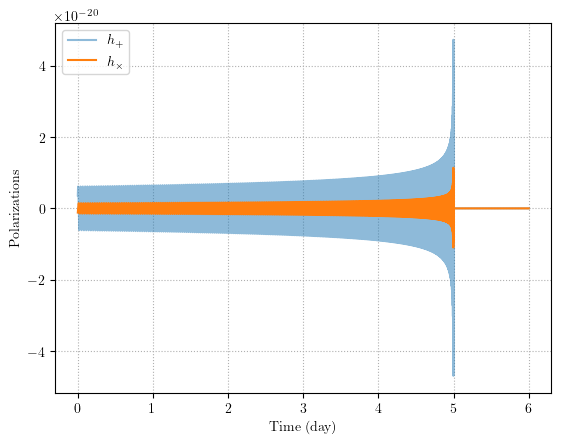

In [12]:
times = np.linspace(0, tc + DAY, int((tc + DAY) / dt))
hp = mbhb.hpfunc(times)
hc = mbhb.hcfunc(times)

plt.plot(times / DAY, hp, alpha=0.5, label=r'$h_+$')
plt.plot(times / DAY, hc, label=r'$h_\times$')
plt.grid(linestyle=':')
plt.xlabel('Time (day)')
plt.ylabel('Polarizations')
plt.legend(loc='upper left')

### 1.2 Simulate interferometry data 

#### data settings 

In [13]:
fsample = 1. 
data_time = 10 * DAY 
ifo_drop_time1 = 0
ifo_drop_time2 = 0
tdi_drop_time1 = 0
tdi_drop_time2 = 0
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 15 

In [14]:
orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB') 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(unit='ffd') 

In [15]:
lam = 3.032776598141215
beta = -1.1817968279048852
psi = 0.2409146690555858
gw = [GW(GWfunc=mbhb, orbit=orbit, ext_params=[lam, beta, psi]),] 

#### generate interferometry data 

In [16]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2, 
    telemetry_downsample=None,
    detrend_order=None,
    acc_noise=False, 
    ro_noise=False,
    laser_noise=False,
    clock_noise=False, 
    ob_noise=False, 
    bl_noise=False,
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw, 
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 
m1.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

### 1.3 TDI combination 

In [17]:
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=interp_order, delay_order=5)
tdi.CalculateXi(doppler=False, pool=pool) # no need to use the doppler delay since there are no laser noise. 
tdi.CalculateEta(doppler=False)
tdi.FastMichelson(doppler=False, channel='AET')

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

#### plot TDI responses (in the fractional frequency difference unit)

Text(0, 0.5, 'TDI')

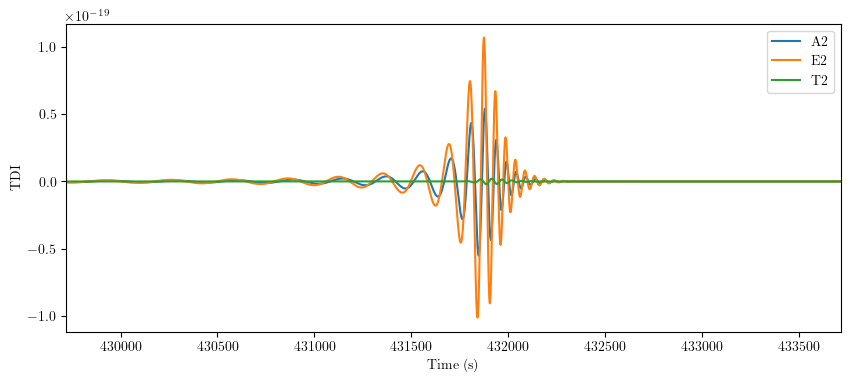

In [18]:
plt.figure(figsize=(10, 4))

# calculate the end time of waveform in the detector frame 
tend_detector = SSBTimetoDetectorTime(time_ssb=mbhb.tend, orbit=orbit, longitude=lam, latitude=beta)

for channel_name in ['A2', 'E2', 'T2']: 
    plt.plot(tdi.measurements['time']['1'][1000:-1000], tdi.measurements[channel_name][1000:-1000]/F_LASER, label=channel_name)
plt.xlim(tend_detector-3000, tend_detector+1000)
# plt.ylim(-1e-21, 1e-21)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('TDI')

## 3. Simulate arbitrary signal from waveform data

### 3.1 create a wrapper for the data 
The waveform wrapper class must contain two functions: 
- hpfunc: $h_+(t)$
- hcfunc: $h_\times(t)$

As an example, we use cubic spline to create the wrapper:

In [19]:
from scipy.interpolate import InterpolatedUnivariateSpline

class GeneralWaveform():
    def __init__(self, tdata, hpdata, hcdata, t0=0):
        tdata_int = tdata - tdata[0] + t0 # shift the starting time to t0 
        self.hpfunc = InterpolatedUnivariateSpline(x=tdata_int, y=hpdata, k=3, ext='zeros')
        self.hcfunc = InterpolatedUnivariateSpline(x=tdata_int, y=hcdata, k=3, ext='zeros')

In [20]:
waveform_data = np.load("GWData/Demo_MBHB_waveform_data.npy")
tdata, hpdata, hcdata = waveform_data.T 

waveform_wrapper = GeneralWaveform(tdata, hpdata, hcdata)

### 3.2 simulate interferometry data and TDI combination 

In [21]:
fsample = 1. 
data_time = 10 * DAY 
ifo_drop_time1 = 0
ifo_drop_time2 = 0
tdi_drop_time1 = 0
tdi_drop_time2 = 0
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 15 

orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB') 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(unit='ffd') 

# randomize extrinsic parameters 
lam = np.random.uniform(0, TWOPI) 
beta = np.arcsin(np.random.uniform(-1, 1))
psi = np.random.uniform(0, PI)
gw = [GW(GWfunc=waveform_wrapper, orbit=orbit, ext_params=[lam, beta, psi]),] 

ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2, 
    telemetry_downsample=None,
    detrend_order=None,
    acc_noise=False, 
    ro_noise=False,
    laser_noise=False,
    clock_noise=False, 
    ob_noise=False, 
    bl_noise=False,
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw, 
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=interp_order, delay_order=5)
tdi.CalculateXi(doppler=False, pool=pool) 
tdi.CalculateEta(doppler=False)
tdi.FastMichelson(doppler=False, channel='AET')

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

Text(0, 0.5, 'TDI')

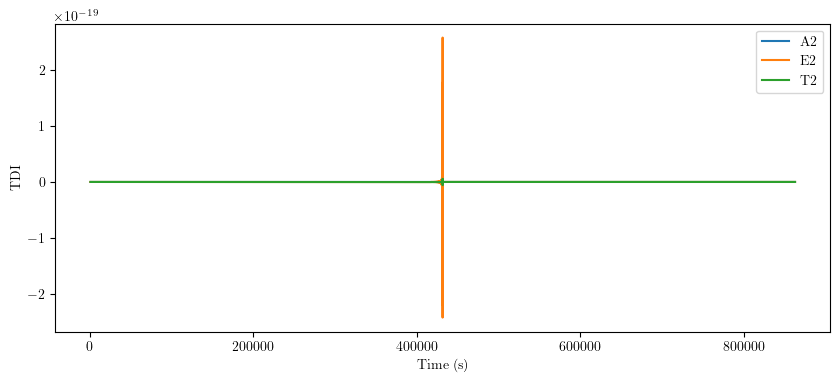

In [22]:
plt.figure(figsize=(10, 4))

for channel_name in ['A2', 'E2', 'T2']: 
    plt.plot(tdi.measurements['time']['1'][1000:-1000], tdi.measurements[channel_name][1000:-1000]/F_LASER, label=channel_name)
plt.legend()
# plt.xlim(4.3e5, 4.34e5)
plt.xlabel('Time (s)')
plt.ylabel('TDI')

## 4. Simulate SGWB 
SGWB signal is simulated as the superposition of numerous stochastic signals. This approach is better than simulating from a spectrum of TDI response in the sense that it incorporates the influence of arm-length variations. 

We use the relationship between GW power spectrum and GW fractional density: 
$$S_{\rm GW}(f) = \frac{3H_0^2}{4\pi^2 f^3}\Omega_{\rm GW}$$

The directions of incident GW signals are generated by the rule of HEALPIX. For an isotropic SGWB, in each direction 
$$S_{\rm GW}(f, \bm{\hat{n}}_k) = \frac{S_{\rm GW}(f)}{N_{\rm pix}}$$ 
$\bm{\hat{n}}_k$ being the unit vector pointing to the center of a certain pixel with index $i$,  ($i \in \{1, N_{\rm pix}\}$).

We then randomly draw the signals $h_+(t, \bm{\hat{n}}_k), h_\times(t, \bm{\hat{n}}_k)$ from $S_{\rm GW}(f, \bm{\hat{n}}_k)$ in all directions. 
<!-- Specifically, the one-sided PSD of $h_A(\bm{\hat{n}}_k)$ ($A \in \{+, \times\}$) is $S_{\rm GW}(f, \bm{\hat{n}}_k)/2$.  -->
Then the incident GW signals are responded by arms according to extrinsic parameters $\{\lambda_i, \beta_i, \psi=0\}$ (since $\psi$ is absorbed into $h_A$). The total single-arm responses read
$$y_{ij}(t) = \sum_{k=1}^{N_{\rm pix}} y_{ij}(t, \bm{\hat{n}}_k)$$

In this tutorial we take as an example the following SGWB model: 
$$\Omega_{\rm GW}(f) = \Omega_0 \left(\frac{f}{f_0}\right)^n$$

To verify the result, we use the theoretical PSD of $X_2$ channel: 
$$S_{X_2}(f) = \mathcal{R}_{X_2}(f) S_{\rm SGWB}(f)$$
In the low-frequency, equal-arm limit, the average response of $X_2$ reads 
$$\mathcal{R}_{X_2}(f) = \frac{48}{5} u^2 \sin^2(u) \sin^2(2u) \left(1 + 0.6u^2\right)^{-1}$$
where $u \equiv 2\pi f L/c$.

### 4.1 Initialize unprojected polarizations 

In [28]:
fsample = 0.1 
data_time = 15 * DAY 
ifo_drop_time1 = 0
ifo_drop_time2 = 0
tdi_drop_time1 = 0
tdi_drop_time2 = 0
size = int((data_time + ifo_drop_time1 + ifo_drop_time2 + tdi_drop_time1 + tdi_drop_time2) * fsample)
interp_order = 31 

offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(unit='ffd') 
orbit = Orbit(OrbitDir='OrbitData/MicroSateOrbitEclipticTCB') 

In [29]:
# define the SGWB fractional density 
def Omega_SGWB(f, Omega0, f0, n): 
    return Omega0 * (f / f0) ** n 

# define the PSD of polarizations 
def S_SGWB(f, Omega0=1e-11, f0=3.162e-3, n=-1.): 
    Omega = Omega_SGWB(f, Omega0, f0, n)
    return 3. * H0 ** 2 / 4. / np.pi ** 2 / f ** 3 * Omega * 1e6 / MPC ** 2 

# get the sky locations 
NSIDE = 5
NPIX = hlp.nside2npix(NSIDE)
print("number of directions:", NPIX)
colatitude, longitude = hlp.pix2ang(nside=NSIDE, ipix=np.arange(NPIX))
latitude = np.pi / 2. - colatitude

# generate stochastic signals in all the directions 
sgwb_generator = GeneralNoise(S_SGWB)
tdata = np.arange(size) / fsample
gw = [] 
for i in tqdm(range(NPIX)): 
    hp_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX * 2.)
    hc_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX * 2.)
    Waveform_k = GeneralWaveform(tdata=tdata, hpdata=hp_k, hcdata=hc_k)
    GW_k = GW(orbit=orbit, ext_params=[longitude[i], latitude[i], 0.], GWfunc=Waveform_k)
    gw.append(GW_k)

number of directions: 1200


100%|██████████| 1200/1200 [09:24<00:00,  2.13it/s]


Text(0, 0.5, 'ASD of polarization')

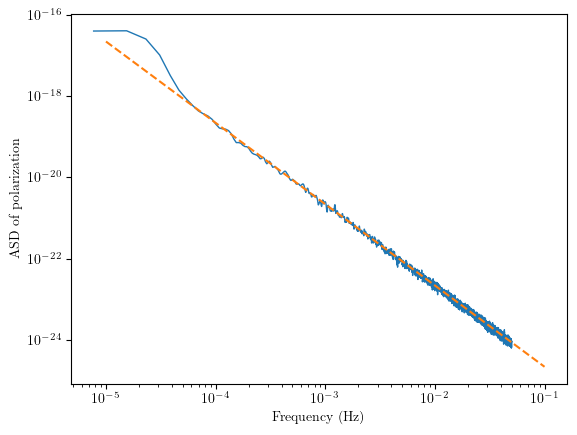

In [30]:
ff, xf = PSD_window(hp_k, fsample, nbin=10, window_type="kaiser", window_args_dict=dict(beta=28))
plt.loglog(ff, np.sqrt(xf), linewidth=1)

plot_freqs = np.logspace(-5, -1, 1000)
plt.loglog(plot_freqs, np.sqrt(S_SGWB(plot_freqs)/NPIX/2), linestyle="--")

plt.xlabel("Frequency (Hz)")
plt.ylabel("ASD of polarization")

### 4.2 Calculate the total single-arm response 

In [31]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    garbage_time1=ifo_drop_time1, 
    garbage_time2=ifo_drop_time2, 
    telemetry_downsample=None,
    detrend_order=None,
    acc_noise=False, 
    ro_noise=False,
    laser_noise=False,
    clock_noise=False, 
    ob_noise=False, 
    bl_noise=False,
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw, 
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

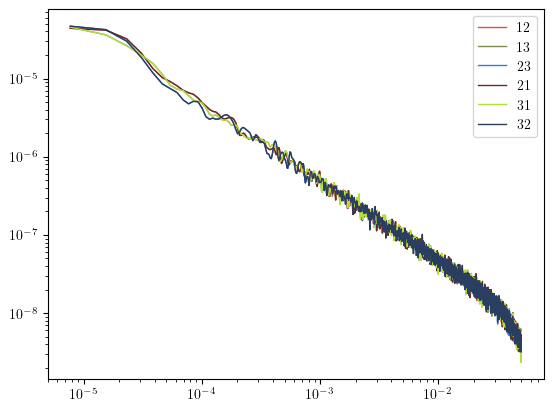

In [32]:
for key in MOSA_labels: 
    ff, xf = PSD_window(m1["sci_c"][key][100:-100], fsample, nbin=10, window_type="kaiser", window_args_dict=dict(beta=28))
    plt.loglog(ff, np.sqrt(xf), linewidth=1, color=MOSA_colors[key], label=key) 
plt.legend(loc="upper right")

### 4.3 TDI combination 

In [33]:
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=interp_order, delay_order=5)
tdi.CalculateXi(doppler=False, pool=pool) 
tdi.CalculateEta(doppler=False)
tdi.FastMichelson(doppler=False, channel='XYZ')

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2'])

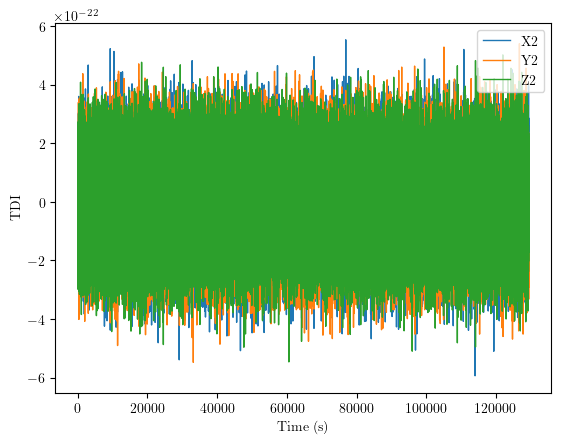

In [34]:
for channel_name in ["X2", "Y2", "Z2"]:
    plt.plot(tdi.measurements[channel_name][100:-100]/F_LASER, label=channel_name, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("TDI")
plt.legend(loc="upper right")

Text(0, 0.5, '${\\rm ASD \\ (Hz^{-1})}$')

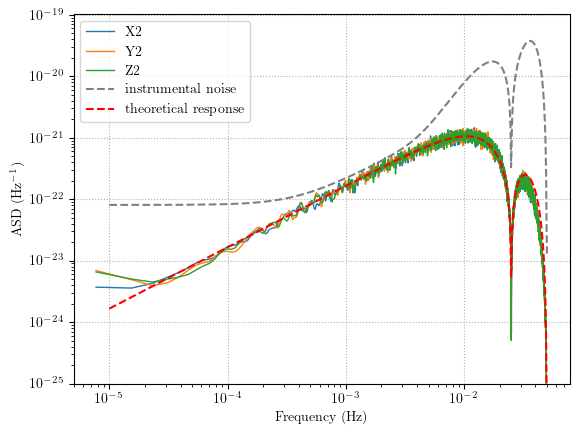

In [36]:
for channel_name in ["X2", "Y2", "Z2"]:
    ff, xf = PSD_window(tdi.measurements[channel_name][100:-100]/F_LASER, fsample, nbin=10, window_type="kaiser", window_args_dict=dict(beta=28))
    plt.loglog(ff, np.sqrt(xf), linewidth=1, label=channel_name) 


plot_freqs = np.logspace(-5, -1.3, 1000)
PSDFunction = TDIPSDs()
plt.loglog(plot_freqs, np.sqrt(PSDFunction.PSD_X2(plot_freqs)), linestyle="--", color='grey', label="instrumental noise") # instrumental noise PSD in the equal-arm limit

plot_u = TWOPI * plot_freqs * L_nominal / C 
ResFunction = 48. / 5. * plot_u ** 2 * np.sin(plot_u) ** 2 * np.sin(2. * plot_u) ** 2 / (1. + 0.6 * plot_u ** 2) # average X2 response function in the equal-arm, long-wavelength limits
plt.loglog(plot_freqs, np.sqrt(ResFunction * S_SGWB(plot_freqs)), linestyle="--", color='red', label="theoretical response")

plt.grid(linestyle=":")
plt.legend(loc="upper left")
plt.ylim(1e-25, )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"${\rm ASD \ (Hz^{-1})}$")